In [1]:
import numpy as np
import pandas as pd
import csv
import torch
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

df = pd.read_csv('/mnt/blossom/more/pbansal/dataset/nyc_taxi/yellow_tripdata_2019-01.csv')
lookup = pd.read_csv('/mnt/blossom/more/pbansal/dataset/nyc_taxi/taxi+_zone_lookup.csv')
zone_lookup = dict({})
borough_to_code = {"Brooklyn":0,"Manhattan":1,"Queens":2,"Bronx":3,"Unknown":4,"EWR":5,"Staten Island":6}
for x in lookup.iterrows():
    zone_lookup[x[1]['LocationID']] = borough_to_code[x[1]['Borough']]

In [2]:
data = df[['tpep_pickup_datetime','PULocationID','DOLocationID','passenger_count']]
data['discrete_time'] = 0
def foo(x):
    date_time = pd.to_datetime(x['tpep_pickup_datetime'])
    return (((date_time.year-2019)*12 + (date_time.month-1))*31 + (date_time.day-1))#*24 + date_time.hour
data['discrete_time'] = data.apply(lambda x : foo(x),axis=1)
# data['DOZone'] = data.apply(lambda x : zone_lookup[x['DOLocationID']],axis=1)
# data['PUZone'] = data.apply(lambda x : zone_lookup[x['PULocationID']],axis=1)

/mnt/a99/d0/pbansal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/a99/d0/pbansal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
removed_zones = [84,103,104,110,176,199,204]
data_19 = data.loc[data['discrete_time'] >= 0].loc[data['discrete_time'] <= 30][['discrete_time','PULocationID','DOLocationID','passenger_count']]
data_19 = data_19.groupby(["discrete_time","PULocationID","DOLocationID"],as_index=False).sum()
data_19 = data_19.loc[~(data_19['PULocationID'].isin(removed_zones))]
data_19 = data_19.loc[~(data_19['DOLocationID'].isin(removed_zones))]

In [4]:
out_array = np.zeros((31,266,266)).astype(np.float)
for x in data_19.iterrows():
    out_array[int(x[1]['discrete_time'])][int(x[1]['PULocationID'])][int(x[1]['DOLocationID'])] = x[1]['passenger_count']

In [5]:
out_array_sub = out_array - np.mean(out_array,axis=0)[None,:,:]
print(out_array.shape)
#print(np.multiply(out_array_sub,out_array_sub).sum(axis=0)[None,:,:])
row_sums = np.sqrt(np.maximum(np.multiply(out_array_sub,out_array_sub),1e-20).sum(axis=0)[None,:,:]/out_array.shape[0])
#row_sums = np.sqrt(np.multiply(out_array_sub,out_array_sub).sum(axis=0)[None,:,:]/out_array.shape[0])
print (row_sums.shape)
norm_out_array = out_array_sub / row_sums
norm_out_array.shape
np.save('dataset/nyc_taxi_norm_mean_numpy_complete',norm_out_array)
# norm_out_array[20,:,138] += 5
# np.save('dataset/nyc_taxi_norm_meadian_numpy_20_138_modified',norm_out_array)

#np.save('dataset/nyc_taxi_norm_meadian_numpy_train',norm_out_array[:700])
#np.save('dataset/nyc_taxi_norm_meadian_numpy_test_7months',norm_out_array[27:])
#np.save('dataset/nyc_taxi_norm_meadian_numpy_test_5months',norm_out_array[29:])
#np.save('dataset/nyc_taxi_norm_meadian_numpy_test_3months',norm_out_array[29:32])
#np.save('dataset/nyc_taxi_norm_meadian_numpy_test_1months',norm_out_array[31:32])
#np.save('dataset/nyc_taxi_norm_meadian_numpy_test_last_2months',norm_out_array[32:])
#np.save('dataset/nyc_taxi_norm_meadian_numpy_test',norm_out_array[700:])

(31, 266, 266)
(1, 266, 266)


In [68]:
# row_sums = np.sqrt(np.maximum(np.multiply(out_array,out_array),1e-20).sum(axis=0)[None,:,:]/out_array.shape[0])
# norm_out_array = out_array / row_sums
# norm_out_array.shape
# np.save('dataset/nyc_taxi_norm_noshift_numpy_complete',norm_out_array)

In [6]:
row_sums = np.std(out_array,axis=0,keepdims=True)
row_sums[row_sums == 0] = 1
norm_out_array = out_array / row_sums
norm_out_array.shape
np.save('dataset/nyc_taxi_norm_noshift_numpy_complete',norm_out_array)

In [10]:
f = open('dataset/nyc_taxi_norm_mean_csv_complete.csv','w')
f.write('time,PUZone,DOZone,Measure\n')
for i in range(norm_out_array.shape[0]):
    for j in range(norm_out_array.shape[1]):    
        for k in range(norm_out_array.shape[2]):
            f.write('%d,%d,%d,%f\n'%(i,j,k,norm_out_array[i][j][k]))

In [84]:
# num_points = int(27*266*266)
# all_examples = np.zeros((num_points,3))
# id_ = 0
# for i in range(2,29):
#     for j in range(266):
#         for k in range(266):
#             all_examples[id_,0] = i
#             all_examples[id_,1] = j
#             all_examples[id_,2] = k
#             id_ += 1
# np.random.shuffle(all_examples)
# test_size = int(all_examples.shape[0]/3)
# np.save('dataset/nyc_taxi_test_examples.npy',all_examples[:test_size])
# np.save('dataset/nyc_taxi_train_examples.npy',all_examples[test_size:])
# #outliers_ = np.concatenate((np.random.randint(2,5,(num_points,1)),np.random.randint(0,60,(num_points,1)),np.random.randint(0,84,(num_points,1))),1)
# num_points = int(26*266*266)
# no20_examples = np.zeros((num_points,3))
# id_ = 0
# for i in range(2,28):
#     for j in range(266):
#         for k in range(266):
#             if (i >= 20):
#                 no20_examples[id_,0] = i+1
#             else : 
#                 no20_examples[id_,0] = i                
#             no20_examples[id_,1] = j
#             no20_examples[id_,2] = k
#             id_ += 1
            
# num_points = int(1*266*266)
# all_20_examples = np.zeros((num_points,3))
# id_ = 0
# for i in range(20,21):
#     for j in range(266):
#         for k in range(266):
#             all_20_examples[id_,0] = i                
#             all_20_examples[id_,1] = j
#             all_20_examples[id_,2] = k
#             id_ += 1
# np.random.shuffle(all_20_examples)
# np.random.shuffle(no20_examples)
# #test_size = int(no20_examples.shape[0]/3)
# np.save('dataset/nyc_taxi_test_all_20_examples.npy',all_20_examples)
# np.save('dataset/nyc_taxi_train_all_no20_examples.npy',no20_examples)


In [7]:
non_zero_non_20_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[data_19['discrete_time'] > 1].loc[data_19['discrete_time'] != 20].loc[data_19['discrete_time'] < 29].loc[data_19['passenger_count'] != 0].to_numpy()
non_zero_20_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[data_19['discrete_time'] == 20].loc[data_19['passenger_count'] != 0].to_numpy()
non_zero_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[data_19['discrete_time'] > 1].loc[data_19['discrete_time'] < 29].loc[data_19['passenger_count'] != 0].to_numpy()
np.random.shuffle(non_zero_non_20_examples)
np.random.shuffle(non_zero_20_examples)
np.random.shuffle(non_zero_examples)
np.save('dataset/nyc_taxi_test_non_zero_examples.npy',non_zero_examples[:int(non_zero_examples.shape[0]/3)])
np.save('dataset/nyc_taxi_train_non_zero_examples.npy',non_zero_examples[int(non_zero_examples.shape[0]/3):])
np.save('dataset/nyc_taxi_test_non_zero_20_examples.npy',non_zero_20_examples)
np.save('dataset/nyc_taxi_train_non_zero_no20_examples.npy',non_zero_non_20_examples)

In [8]:
non_zero_remove2zones_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[(data_19['discrete_time'] < 29) & (data_19['discrete_time'] > 1)].loc[(data_19['PULocationID'] != 138)&(data_19['DOLocationID'] != 100)].loc[data_19['passenger_count'] != 0].to_numpy()
non_zero_2zones_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[(data_19['discrete_time'] < 29) & (data_19['discrete_time'] > 1)].loc[(data_19['PULocationID'] == 138)&(data_19['DOLocationID'] == 100)].loc[data_19['passenger_count'] != 0].to_numpy()
np.random.shuffle(non_zero_remove2zones_examples)
np.random.shuffle(non_zero_2zones_examples)
np.save('dataset/nyc_taxi_test_non_zero_2zones_examples.npy',non_zero_2zones_examples)
np.save('dataset/nyc_taxi_train_non_zero_2zones_examples.npy',non_zero_remove2zones_examples)

In [9]:
non_zero_zonetime_train_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[(data_19['discrete_time'] < 29) & (data_19['discrete_time'] != 20) & (data_19['discrete_time'] > 1)].loc[data_19['DOLocationID'] != 138].loc[data_19['passenger_count'] != 0].to_numpy()
non_zero_zonetime_test_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[data_19['discrete_time'] == 20].loc[data_19['DOLocationID'] == 138].loc[data_19['passenger_count'] != 0].to_numpy()
np.random.shuffle(non_zero_zonetime_train_examples)
np.random.shuffle(non_zero_zonetime_test_examples)
np.save('dataset/nyc_taxi_test_non_zero_zonetime_100%_examples.npy',non_zero_zonetime_test_examples)
np.save('dataset/nyc_taxi_train_non_zero_zonetime_100%_examples.npy',non_zero_zonetime_train_examples)
np.save('dataset/nyc_taxi_test_non_zero_zonetime_50%_examples.npy',non_zero_zonetime_test_examples[:int(non_zero_zonetime_test_examples.shape[0]/2)])
np.save('dataset/nyc_taxi_train_non_zero_zonetime_50%_examples.npy',np.concatenate([non_zero_zonetime_train_examples,non_zero_zonetime_test_examples[int(non_zero_zonetime_test_examples.shape[0]/2):]],axis=0))


In [15]:
np.random.seed(42)

non_zero_non_20_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[data_19['discrete_time'] > 1].loc[data_19['discrete_time'] != 20].loc[data_19['discrete_time'] < 29].loc[data_19['passenger_count'] != 0].to_numpy()
non_zero_20_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[data_19['discrete_time'] == 20].loc[data_19['passenger_count'] != 0].to_numpy()
np.random.shuffle(non_zero_non_20_examples)
np.random.shuffle(non_zero_20_examples)
size_=100
our_outlier_set = non_zero_non_20_examples[:size_]
our_non_outlier_set = non_zero_20_examples[:size_]
our_train_set = non_zero_non_20_examples[size_:]
np.save('dataset/nyc_taxi_train_our_examples.npy',our_train_set[size_:])
np.save('dataset/nyc_taxi_test_our_outlier_examples.npy',our_outlier_set)
np.save('dataset/nyc_taxi_test_our_inlier_examples.npy',our_non_outlier_set)
np.save('dataset/nyc_taxi_test_our_truly_inlier_examples.npy',our_train_set[:size_])

out_array_sub = out_array - np.mean(out_array,axis=0)[None,:,:]
row_sums = np.sqrt(np.maximum(np.multiply(out_array_sub,out_array_sub),1e-20).sum(axis=0)[None,:,:]/out_array.shape[0])
norm_out_array = out_array_sub / row_sums
np.save('dataset/nyc_taxi_norm_mean_numpy_complete.npy',norm_out_array)

for i in range(non_zero_20_examples.shape[0]):
    norm_out_array[non_zero_20_examples[i][0],non_zero_20_examples[i][1],non_zero_20_examples[i][2]] += 3
for i in range(100):
    norm_out_array[non_zero_non_20_examples[i][0],non_zero_non_20_examples[i][1],non_zero_non_20_examples[i][2]] += 3
np.save('dataset/nyc_taxi_norm_mean_numpy_our.npy',norm_out_array)

In [70]:
######### Generate outlier validation set ##################
test_set = np.load('dataset/nyc_taxi_norm_meadian_numpy_test.npy')
#print (test_set.shape)
num_points = 1000
#45,266,7
outliers_ = np.concatenate((np.random.randint(2,43,(num_points,1)),np.random.randint(0,266,(num_points,1)),np.random.randint(0,7,(num_points,1))),1)
for x in outliers_ :
    test_set[x[0],x[1],x[2]] += 3
np.save('dataset/nyc_taxi_norm_meadian_numpy_test_modified_our.npy',test_set)
np.save('dataset/nyc_taxi_norm_meadian_numpy_test_modified_org_rvae.npy',test_set[2:43])
outliers_ = np.unique(outliers_,axis=0)
print (outliers_.shape)
outliers_ = outliers_.tolist()
# plt.scatter(test_set[1],np.zeros(test_set[1].shape))
# np.where(test_set[1]>5.5)

(995, 3)


In [70]:
from helper import NN, Dataset_
device = torch.device('cuda:1')
loss = torch.nn.L1Loss()
batch_size = 128
#test_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_modified.npy','dataset/nyc_taxi_test_all_20_examples.npy')
#test_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_complete.npy','dataset/nyc_taxi_test_examples.npy')
test_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_138_modified.npy','dataset/nyc_taxi_test_non_zero_zonetime_100%_examples.npy')
#test_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_modified.npy','dataset/nyc_taxi_test_non_zero_20_examples.npy')
#test_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_complete.npy','dataset/nyc_taxi_test_non_zero_examples.npy')
#test_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_complete.npy','dataset/nyc_taxi_test_non_zero_2zones_examples.npy')

test_loader = torch.utils.data.DataLoader(test_set,batch_size = batch_size,drop_last = False)
model = NN().to(device)
epoch = 11
model.load_state_dict(torch.load('/mnt/blossom/more/pbansal/nyc_checkpoints/checkpoint_%d'%epoch))
pred_ = []
loss_ = 0
for x,y,index in test_loader :
    with torch.no_grad():
        x = x.to(device)
        y_pred = model(x)
        y = y.to(device)
        loss_ += loss(y,y_pred).data*x.shape[0]
        for i in range(x.shape[0]):
            y_ = y[i].data.cpu().numpy() 
            pre_ = y_pred[i].data.cpu().numpy()
            pred_.append([y_,pre_])
#             if (abs(y_-pre_)>3):
#                 outliers.append(((index[0][i],index[1][i],index[2][i]),(y_,pre_)))
loss_ = (loss_/int(len(test_set)))
print (loss_)
pred_ = np.array(pred_)

loading dataset
tensor(1.3778, device='cuda:1')


In [73]:
from ConditionalPredictor.helper import Dataset_,NN

import os
device = torch.device('cuda:1')
batch_size = 64
pred_cond_pred = []
def test_ ():
    #val_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_modified.npy','dataset/nyc_taxi_test_all_20_examples.npy')
    #val_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_complete.npy','dataset/nyc_taxi_test_examples.npy')
    val_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_138_modified.npy','dataset/nyc_taxi_test_non_zero_zonetime_100%_examples.npy')
    #val_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_modified.npy','dataset/nyc_taxi_test_non_zero_20_examples.npy')
    #val_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_complete.npy','dataset/nyc_taxi_test_non_zero_examples.npy')
    #val_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_complete.npy','dataset/nyc_taxi_test_non_zero_2zones_examples.npy')

    val_loader = torch.utils.data.DataLoader(val_set,shuffle=True,batch_size = batch_size,drop_last=False)
    model = NN().to(device)
    loss = torch.nn.L1Loss()
    epoch = 99
    model.load_state_dict(torch.load(os.path.join('/mnt/blossom/more/pbansal/nyc_checkpoints_cond_pred/','checkpoint_%d'%epoch)))
    loss_ = 0
    for x,y,_ in val_loader :
        with torch.no_grad():
            x = x.to(device)
            y_pred = model(x)
            y = y.to(device)
            loss_ += loss(y,y_pred).data*x.shape[0]
            for i in range(x.shape[0]):
                y_ = y[i].data.cpu().numpy() 
                pre_ = y_pred[i].data.cpu().numpy()
                pred_cond_pred.append([y_,pre_])
    loss_ = loss_/int(len(val_set))
    return loss_
print (test_()) 
pred_cond_pred = np.array(pred_cond_pred)

loading dataset
tensor(3.6148, device='cuda:1')


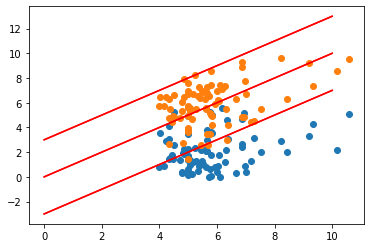

In [74]:
def plot(pred_):
    plt.scatter(pred_[:,0],pred_[:,1])#,alpha=0.2,marker='.')
#     plt.plot([-6,6],[-6,6],c='r')
#     plt.plot([-6,6],[-3,9],c='r')
#     plt.plot([-6,6],[-9,3],c='r')
    plt.plot([0,10],[0,10],c='r')
    plt.plot([0,10],[3,13],c='r')
    plt.plot([0,10],[-3,7],c='r')
plot(pred_cond_pred[:,:])
plot(pred_[:,:])

In [39]:
def test_ (model,val_set):
    device = torch.device('cuda:1')
    batch_size = 64
    preds = []
    val_loader = torch.utils.data.DataLoader(val_set,shuffle=True,batch_size = batch_size,drop_last=False)
    model = model.to(device)
    loss_ = 0
    for x,y,index in val_loader :
        with torch.no_grad():
            x = x.to(device)
            y_pred,var = model(x)
            y = y.to(device)
            pred = ((y_pred-y)**2)/var + var
            loss_ +=  pred.mean().data*x.shape[0]
            pred = torch.exp(-0.5*pred).data
            for i in range(x.shape[0]):
                preds.append(((int(index[0][i]),int(index[1][i]),int(index[2][i])),float(pred[i]),float(var[i]),float(y_pred[i]),x[i].cpu()))
    loss_ = loss_/int(len(val_set))
    return loss_,np.array(preds)

In [8]:
import helper
import importlib
importlib.reload(helper)
######## Contextual Analysis ####################

# val_set1 = Dataset_('dataset/nyc_taxi_norm_noshift_numpy_our.npy','dataset/nyc_taxi_test_our_outlier_examples.npy')
# val_set2 = Dataset_('dataset/nyc_taxi_norm_noshift_numpy_our.npy','dataset/nyc_taxi_test_our_inlier_examples.npy')
# val_set3 = Dataset_('dataset/nyc_taxi_norm_noshift_numpy_complete.npy','dataset/nyc_taxi_test_our_truly_inlier_examples.npy')
val_set3 = helper.Dataset_('dataset/nyc_taxi_norm_noshift_numpy_complete.npy','dataset/nyc_taxi_test_non_zero_examples.npy')
epoch = 33
model = helper.NN()
model.load_state_dict(torch.load('/mnt/blossom/more/pbansal/nyc_checkpoints/checkpoint_%d'%epoch))

#  t_,outlier_scores = test_(model,val_set1)
# _,inlier_scores = test_(model,val_set2)
_,truly_inlier_scores = test_(model,val_set3)

loading dataset


/mnt/a99/d0/pbansal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [40]:
from ConditionalPredictor.helper import Dataset_ as CondDataset
from ConditionalPredictor.helper import NN as CondNN
from helper import NN, Dataset_

######## CondPred Analysis ####################

# val_set1 = CondDataset('dataset/nyc_taxi_norm_mean_numpy_our.npy','dataset/nyc_taxi_test_our_outlier_examples.npy')
# val_set2 = CondDataset('dataset/nyc_taxi_norm_mean_numpy_our.npy','dataset/nyc_taxi_test_our_inlier_examples.npy')
val_set3 = CondDataset('dataset/nyc_taxi_norm_noshift_numpy_complete.npy','dataset/nyc_taxi_test_non_zero_examples.npy')
epoch = 25
model = CondNN()
model.load_state_dict(torch.load('/mnt/blossom/more/pbansal/nyc_checkpoints_cond_pred/checkpoint_%d'%epoch))

# _,cond_outlier_scores = test_(model,val_set1)
# _,cond_inlier_scores = test_(model,val_set2)
_,cond_truly_inlier_scores = test_(model,val_set3)

loading dataset


/mnt/a99/d0/pbansal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(array([ 6636.,  6220.,  8899., 12529., 16443., 21450., 16800.,  3609.,
          681.,    80.]),
 array([1.882782640905134e-07, 0.09508397834936347, 0.19016776842046285,
        0.28525155849156225, 0.3803353485626616, 0.47541913863376095,
        0.5705029287048604, 0.6655867187759598, 0.7606705088470591,
        0.8557542989181585, 0.9508380889892578], dtype=object),
 <a list of 10 Patch objects>)

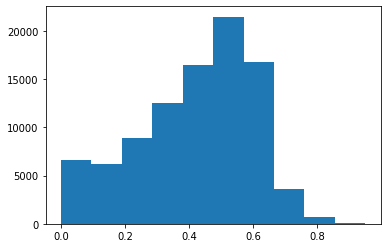

In [42]:
# plt.hist(cond_inlier_scores[:,1])
# plt.hist(inlier_scores[:,1])
# plt.hist(cond_outlier_scores[:,1])
# plt.hist(outlier_scores[:,1])
#plt.hist(cond_truly_inlier_scores[:,1])
plt.hist(cond_truly_inlier_scores[:,1])

In [47]:
# temp = truly_inlier_scores[np.argsort(truly_inlier_scores[:,1])]
temp_cond = cond_truly_inlier_scores[np.argsort(cond_truly_inlier_scores[:,1])]
temp_cond1 = truly_inlier_scores[np.argsort(cond_truly_inlier_scores[:,1])]

In [44]:
complete = np.load('dataset/nyc_taxi_norm_noshift_numpy_complete.npy')

In [7]:
[(14,145,145),(20, 36, 112),(20, 148, 138)]

In [31]:
for i,x in enumerate(temp):
    if (x[0] == (20,249,246)):
        print (i)

32433


In [55]:
i = 5
x = temp_cond
print(x[i])
visualise(x[i][0],x[i][1],complete)

[(28, 168, 261) 3.465750523901079e-06 0.864399254322052 1.0785037279129028
 tensor([ 28., 168., 261.])]
Index is :  (28, 168, 261)
True Value : 1, Normalised Value : 5.659800, Inlier Prob : 0.000003
Time Series Values : 
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         5.65979976 0.
 0.        ]
Relaxing Time : 
        discrete_time  PULocationID  DOLocationID  passenger_count
299133             28           168           261                1


In [30]:
i = 0
print(temp_cond[i])
visualise(temp_cond[i][0],temp_cond[i][1],complete)

[(20, 249, 246) 0.0 0.029331296682357788 1.1935336589813232
 tensor([ 20., 249., 246.])]
Index is :  (20, 249, 246)
True Value : 102, Normalised Value : 1.894253, Inlier Prob : 0.000000
Time Series Values : 
[2.06139282 2.15424836 3.47279692 3.52851024 3.93707458 2.89709262
 2.8599504  3.49136803 4.19707007 4.53134999 5.32990757 5.34847868
 4.12278565 3.67707909 4.12278565 3.50993913 4.23421229 4.53134999
 4.32706782 3.88136126 1.89425287 4.51277888 3.23137253 4.49420778
 4.90277212 6.75988277 3.76993462 2.97137704 2.97137704 3.52851024
 4.30849671]
Relaxing Time : 
        discrete_time  PULocationID  DOLocationID  passenger_count
10614               0           249           246              111
20814               1           249           246              116
31462               2           249           246              187
42244               3           249           246              190
52186               4           249           246              212
62364               5    

0.76125
0.8645999999999999


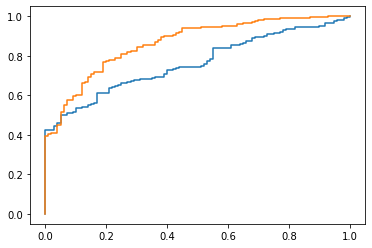

In [160]:
from sklearn.metrics import roc_auc_score,roc_curve,auc,brier_score_loss,accuracy_score
import matplotlib.pyplot as plt

y_pred = np.concatenate([cond_outlier_scores[:,1],cond_inlier_scores[:,1],cond_truly_inlier_scores[:,1]])
y_true = np.concatenate([np.zeros(cond_outlier_scores[:,1].shape),np.ones(cond_inlier_scores[:,1].shape),np.ones(cond_truly_inlier_scores[:,1].shape)])
fpr, tpr, threshold = roc_curve(y_true,y_pred)
print(auc(fpr,tpr))
plt.plot(fpr,tpr)

y_pred = np.concatenate([outlier_scores[:,1],inlier_scores[:,1],truly_inlier_scores[:,1]])
y_true = np.concatenate([np.zeros(outlier_scores[:,1].shape),np.ones(inlier_scores[:,1].shape),np.ones(truly_inlier_scores[:,1].shape)])
fpr, tpr, threshold = roc_curve(y_true,y_pred)
print(auc(fpr,tpr))
plt.plot(fpr,tpr)

In [9]:
def visualise(index,pred,norm_out_array):
    print ("Index is : ",index)
    true_value = int(data_19.loc[(data_19["discrete_time"] == index[0]) & (data_19["PULocationID"] == index[1]) & (data_19["DOLocationID"] == index[2])]['passenger_count'])
    time_series_value = norm_out_array[:,index[1],index[2]]
    normalised_value = time_series_value[index[0]]
    print ("True Value : %d, Normalised Value : %f, Inlier Prob : %f"%(true_value,normalised_value,pred))
    print ("Time Series Values : ")
    print (time_series_value)
#     print ("Relaxing DOLocation : ")
#     print (data_19.loc[(data_19["discrete_time"] == index[0]) & (data_19["PULocationID"] == index[1])])
#     print ("Relaxing PULocation : ")
#     print (data_19.loc[(data_19["discrete_time"] == index[0]) & (data_19["DOLocationID"] == index[2])])    
    print ("Relaxing Time : ")
    print (data_19.loc[(data_19["PULocationID"] == index[1]) & (data_19["DOLocationID"] == index[2])])
    